#Price Momentum Factor Algorithm

By Gil Wassermann

Strategy taken from "130/30: The New Long-Only" by Andrew Lo and Pankaj Patel

Part of the Quantopian Lecture Series:
* www.quantopian.com/lectures
* github.com/quantopian/research_public

Notebook released under the Creative Commons Attribution 4.0 License. Please do not remove this attribution.

Let us imagine that we are traders at a large bank, watching out screens as stock prices fluctuate up and down. Suddenly, everyone around us is buying one particular security. Demand has increased so the stock price increases. We panic. Is there some information that we missed out on -are we out of the loop? In our panic, we blindly decide to buy some shares so we do not miss the boat on the next big thing. Demand further increases as a result of the hype surrounding the stock, driving up the price even more. 

Now let us take a step back. From the observational perspective of a quant, the price of the security is increasing because of the animal spirits of investors. In essence, the price is going up because the price is going up. As quants, if we can identify these irrational market forces, we can profit from them.

In this notebook we will go step-by-step through the contruction of an algorithm to find and trade equities experiencing momentum in price.

First, let us import all the necessary libraries for our algorithm.

In [1]:
import numpy as np
import pandas as pd
from scipy.signal import argrelmin, argrelmax
import statsmodels.api as sm
import talib
import matplotlib.pyplot as plt
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import Latest
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.research import run_pipeline
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import CustomFactor

#Price Momentum

In this notebook, we will use indicators outlined in "130/30: The New Long Only" by Andrew Lo and Pankaj Patel and combine them to create a single factor. It should be clarified that we are looking for long-term momentum as opposed to intra-day momentum. These indicators are:

* Slope of the 52-Week Trendline (20-day Lag)
* Percent Above 260-Day Low (20-day Lag)
* 4/52-Week Oscillator (20-day Lag)
* 39-Week Return (20-day Lag)

##Lag

One thing that all of the indicators have in common is that they are calculated using a 20-day lag. This lag is a way of smoothing out the stock signal so that we can filter out noise and focus on concrete, underlying trends. To calculate lag, we will take our desired data series and calculate its 20-day simple moving average, which is the arithmetic mean of window of the series' last 20 entries. 

Let's see an example of this for the closing price of Apple (AAPL) stock from August 2014 to August 2015. We will abstract out the lag calculation into a helper function because we will be needing it so often in the algorithm.

NB: we remove the first 20 entries of the results as these will always be undefined (here, NaN) as because there is not a 20-day window with which to calculate the lag. We also have a check to determine if the entire row of data in NaN, as this can cause issues with the TA-Lib library.

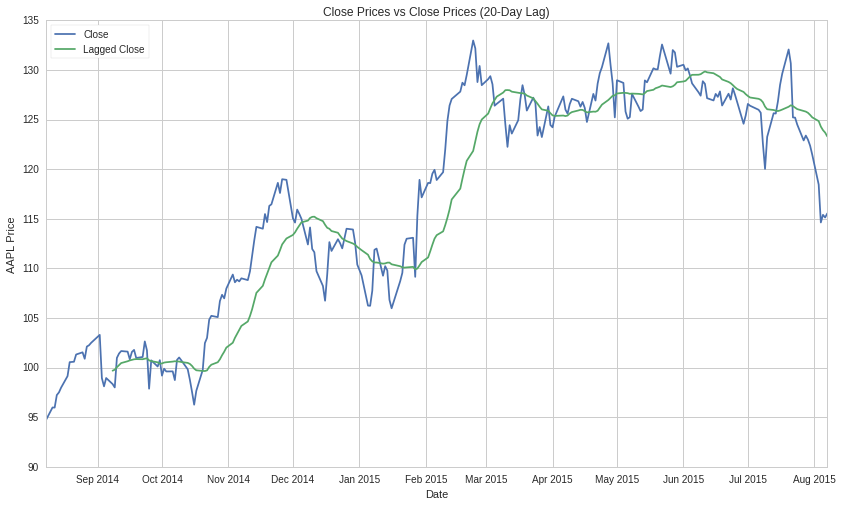

In [2]:
# check if entire column is NaN. If yes, return True
def nan_check(col):
    if np.isnan(np.sum(col)):
        return True
    else: 
        return False

# helper to calculate lag
def lag_helper(col):
    
    # TA-Lib raises an error if whole colum is NaN,
    # so we check if this is true and, if so, skip
    # the lag calculation
    if nan_check(col):
        return np.nan
    # 20-day simple moving average
    else:
        return talib.SMA(col, 20)[20:]

AAPL_frame = get_pricing('AAPL', start_date='2014-08-08', end_date='2015-08-08', fields='close_price')

# convert to np.array for helper function and save index of timeseries
AAPL_index = AAPL_frame.index
AAPL_frame = AAPL_frame.as_matrix()

# calculate lag
AAPL_frame_lagged = lag_helper(AAPL_frame)

plt.plot(AAPL_index, AAPL_frame, label='Close')
plt.plot(AAPL_index[20:], AAPL_frame_lagged, label='Lagged Close')
plt.legend(loc=2)
plt.xlabel('Date')
plt.title('Close Prices vs Close Prices (20-Day Lag)')
plt.ylabel('AAPL Price');

As you can see from the graph, the lagged closing prices generally follow the same general pattern as the unlagged prices, but do not experience as extreme peaks and troughs. For the rest of the notebook we will use lagged prices as we are interested in long-term trends.

## Slope of 52-Week Trendline

One of the oldest indicators of price momentum is the trendline. The basic idea is to create a bounding line around stock prices that predict when a price should pivot. A trendline that predicts a ceiling is called a resistance trendline, and one that predicts a floor is a support trendline. 

To calculate a support trendline here, we take a lagged series, and find its pronounced local minima (here, a local minimum is defined as a data point lower than the five previous and five proceeding points). We then connect the first local minimum and the last local minimum by a straight line. For a resistance trendline, the process is the same, except it uses local maxima. This is just one of many methodologies for calculating trendlines.

Let us code up a function to return the gradient of the trendline. We will include a boolean variable `support` that, when set to `True` gives a support trendline and when set to `False` gives a resistance trendline. Let us have a look at the same dataset of AAPL stock and plot its trendlines. 

NB: The y-intercepts used here are purely aesthetic and have no meaning as the indicator itself is only based on the slope of the trendline  

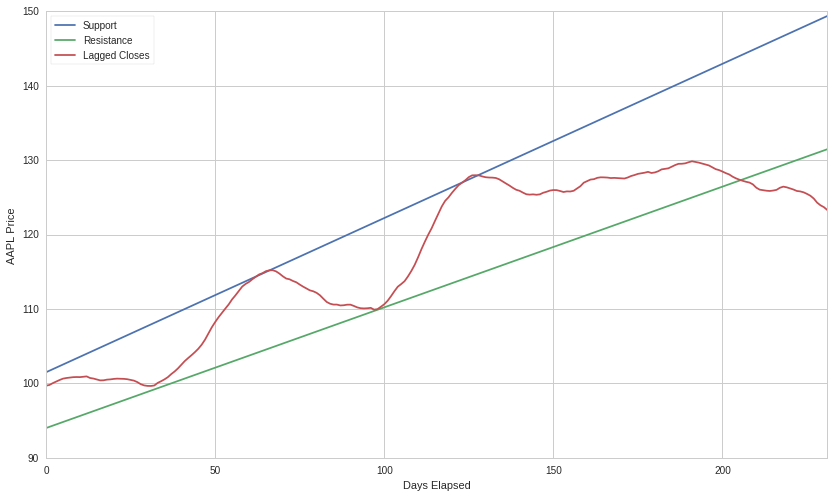

In [3]:
# Custom Factor 1 : Slope of 52-Week trendline
def trendline_function(col, support):
    
    # NaN check for speed
    if nan_check(col):
        return np.nan  
    
    # lag transformation
    col = lag_helper(col)
    
    # support trendline
    if support:
        
        # get local minima
        minima_index = argrelmin(col, order=5)[0]
        
        # make sure line can be drawn
        if len(minima_index) < 2:
            return np.nan
        else:
            # return gradient
            return (col[minima_index[-1]] - col[minima_index[0]]) / (minima_index[-1] - minima_index[0])
    
    # resistance trandline
    else:
        
        # get local maxima
        maxima_index = argrelmax(col, order=5)[0]
        if len(maxima_index) < 2:
            return np.nan
        else:
            return (col[maxima_index[-1]] - col[maxima_index[0]]) / (maxima_index[-1] - maxima_index[0])

# make the lagged frame the default 
AAPL_frame = AAPL_frame_lagged

# use day count rather than dates to ensure straight lines
days = list(range(0,len(AAPL_frame),1))

# get points to plot
points_low = [(101.5 + (trendline_function(AAPL_frame, True)*day)) for day in days]
points_high = [94 + (trendline_function(AAPL_frame, False)*day) for day in days]

# create graph
plt.plot(days, points_low, label='Support')
plt.plot(days, points_high, label='Resistance')
plt.plot(days, AAPL_frame, label='Lagged Closes')
plt.xlim([0, max(days)])
plt.xlabel('Days Elapsed')
plt.ylabel('AAPL Price')
plt.legend(loc=2);

As you can see, at the beginning of the time frame these lines seem to describe the pivot points of the curve well. Therefore it appears that betting against the stock when its price nears the resistance line and betting on the stock when its price nears the support line is a decent strategy. One issue with this is that these trendlines change over time. Even at the end of the above graph, it appears that the lines need to be redrawn in order to accomodate new prevailing price trends.

Now let us create our factor. In order to maintain flexibility between the types of trendlines, we need a way to pass the variable `support` into our Pipeline calculation. To do this we create a function that returns a `CustomFactor class` that *can* take a variable that is in scope of our indicator.

Also, we have abstracted out the trendline calculation so that we can use the builtin Numpy function `apply_along_axis` instead of creating and appending the results of the trendline calculation for each column to a list, which is a slower process.

In [4]:
def create_trendline_factor(support):
    
    class Trendline(CustomFactor):

        # 52 week + 20d lag
        window_length = 272
        inputs=[USEquityPricing.close]

        def compute(self, today, assets, out, close): 
            out[:] = np.apply_along_axis(trendline_function, 0, close, support)
    return Trendline
    
temp_pipe_1 = Pipeline()
trendline = create_trendline_factor(support=True)
temp_pipe_1.add(trendline(), 'Trendline')
results_1 = run_pipeline(temp_pipe_1, '2015-08-08', '2015-08-08')
results_1.head(20)

Trendline
2015-08-10 00:00:00+00:00 Equity(2 [AA])      -0.020134
                          Equity(21 [AAME])         NaN
                          Equity(24 [AAPL])    0.134210
                          Equity(25 [AA_PR])        NaN
                          Equity(31 [ABAX])    0.026059
                          Equity(39 [DDC])     0.027155
                          Equity(41 [ARCB])   -0.015297
                          Equity(52 [ABM])     0.032766
                          Equity(53 [ABMD])    0.185881
                          Equity(62 [ABT])     0.030551
                          Equity(64 [ABX])    -0.044889
                          Equity(66 [AB])      0.034333
                          Equity(67 [ADSK])   -0.009252
                          Equity(69 [ACAT])   -0.014448
                          Equity(70 [VBF])    -0.000941
                          Equity(76 [TAP])     0.006323
                          Equity(84 [ACET])    0.026783
                          Equity(86 [ACG])     0.001448
                          Equity(88 [ACI])    -1.289812
                          Equity(100 [IEP])   -0.078825

## Percent Above 260-Day Low

This indicator is relatively self explanitory. Whereas the trendline metric gives a more indepth picture of price momentum (as the line itself shows how this momentum has evolves over time), this metric is fairly blunt. It is calculated as the price of a stock today less the minimum price in a retrospective 260-day window, all divided by that minimum price.

Let us have a look at a visualization of this metric for the same window of AAPL stock.

Percent above 260-day Low: 25.114962%


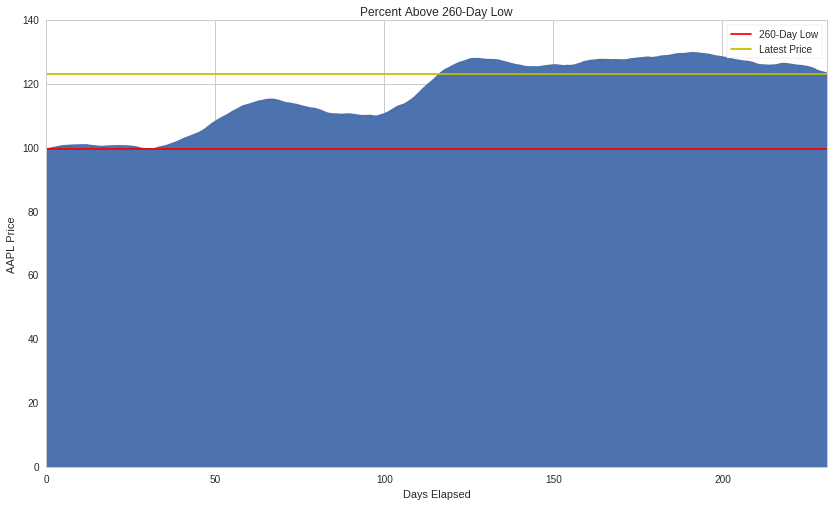

In [5]:
# Custom Factor 2 : % above 260 day low
def percent_helper(col):
    if nan_check(col):
        return np.nan 
    else:
        col = lag_helper(col)
        return (col[-1] - min(col)) / min(col)

print 'Percent above 260-day Low: %f%%' % (percent_helper(AAPL_frame) * 100)

# create the graph
plt.plot(days, AAPL_frame)
plt.axhline(min(AAPL_frame), color='r', label='260-Day Low')
plt.axhline(AAPL_frame[-1], color='y', label='Latest Price')
plt.fill_between(days, AAPL_frame)
plt.xlabel('Days Elapsed')
plt.ylabel('AAPL Price')
plt.xlim([0, max(days)])
plt.title('Percent Above 260-Day Low')
plt.legend();

Now we will create the `CustomFactor` for this metric. We will use the same abstraction process as above for run-time efficiency.

In [6]:
class Percent_Above_Low(CustomFactor):
    
    # 260 days + 20 lag
    window_length = 280
    inputs=[USEquityPricing.close]
    
    def compute(self, today, asseys, out, close):
        out[:] = np.apply_along_axis(percent_helper, 0, close)

temp_pipe_2 = Pipeline()
temp_pipe_2.add(Percent_Above_Low(), 'Percent Above Low')
results_2 = run_pipeline(temp_pipe_2, '2015-08-08', '2015-08-08')
results_2.head(20)

Percent Above Low
2015-08-10 00:00:00+00:00 Equity(2 [AA])               0.000000
                          Equity(21 [AAME])                 NaN
                          Equity(24 [AAPL])            0.314374
                          Equity(25 [AA_PR])                NaN
                          Equity(31 [ABAX])            0.189924
                          Equity(39 [DDC])             0.000000
                          Equity(41 [ARCB])            0.020620
                          Equity(52 [ABM])             0.327307
                          Equity(53 [ABMD])            2.256132
                          Equity(62 [ABT])             0.238078
                          Equity(64 [ABX])             0.000000
                          Equity(66 [AB])              0.175879
                          Equity(67 [ADSK])            0.006031
                          Equity(69 [ACAT])            0.000000
                          Equity(70 [VBF])             0.004431
                          Equity(76 [TAP])             0.029064
                          Equity(84 [ACET])            0.415219
                          Equity(86 [ACG])             0.054047
                          Equity(88 [ACI])             0.000000
                          Equity(100 [IEP])            0.000000

NB: There are a lot of 0's here for this output. Although this might seem odd at first, it makes sense when we consider that there are many securities on a downwards trend. These stocks would be prime candidates to give a value of 0 as their current price is as low as it has ever been in this lookback window.

##4/52-Week Price Oscillator

This is calculated as the average close price over 4 weeks over the average close price over 52 weeks, all subtracted by 1. To understand this value measures, let us consider what happens to the oscillator in different scenarios. This particular oscillator gives a sense of relative performance between the previous four weeks and the previous year. A value given by this oscillator could be "0.05", which would indicate that the stocks recent closes are outperforming its previous year's performance by 5%. A positive value is an indicator of momentum as more recent performance is stronger than normal and the larger the number, the more momentum.

As close prices can not be negative, this oscillator is bounded by -1 and positive infinity. Let us create a graph to show how, given a particular 52-week average, the value of the oscillator is affected by its four-week average.

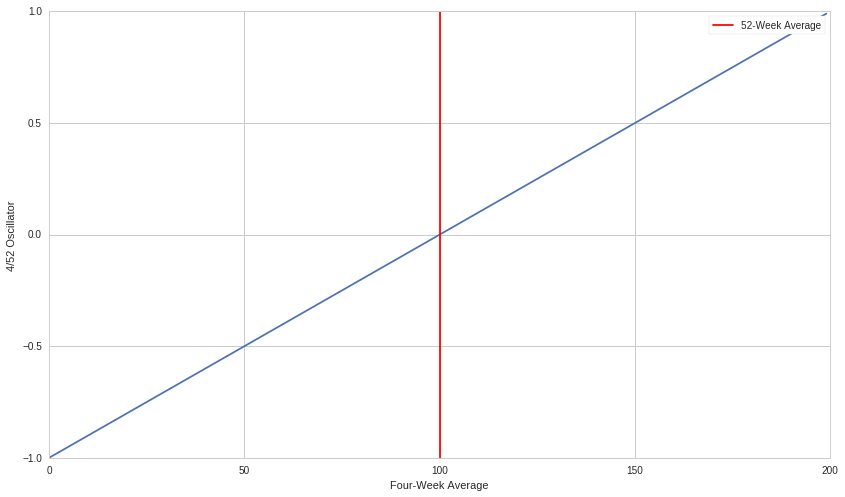

In [7]:
# set 48-week average
av_52w = 100.

# create list of possible last four-week averages
av_4w = xrange(0,200)

# create list of oscillator values
osc = [(x / av_52w) - 1 for x in av_4w]

# draw graph
plt.plot(av_4w, osc)
plt.axvline(100, color='r', label='52-Week Average')
plt.xlabel('Four-Week Average')
plt.ylabel('4/52 Oscillator')
plt.legend();

Now let us create a Pipeline factor and observe some values.

In [8]:
# Custom Factor 3: 4/52 Price Oscillator
def oscillator_helper(col):
    if nan_check(col):
        return np.nan   
    else:
        col = lag_helper(col)
        return np.nanmean(col[-20:]) / np.nanmean(col) - 1

class Price_Oscillator(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 272
    
    def compute(self, today, assets, out, close):
        out[:] = np.apply_along_axis(oscillator_helper, 0, close)
        
temp_pipe_3 = Pipeline()
temp_pipe_3.add(Price_Oscillator(), 'Price Oscillator')
results_3 = run_pipeline(temp_pipe_3, '2015-08-08', '2015-08-08')
results_3.head(20)

Price Oscillator
2015-08-10 00:00:00+00:00 Equity(2 [AA])             -0.271287
                          Equity(21 [AAME])                NaN
                          Equity(24 [AAPL])           0.089667
                          Equity(25 [AA_PR])               NaN
                          Equity(31 [ABAX])          -0.046013
                          Equity(39 [DDC])           -0.159902
                          Equity(41 [ARCB])          -0.163490
                          Equity(52 [ABM])            0.120786
                          Equity(53 [ABMD])           0.473859
                          Equity(62 [ABT])            0.107602
                          Equity(64 [ABX])           -0.269565
                          Equity(66 [AB])             0.059691
                          Equity(67 [ADSK])          -0.083954
                          Equity(69 [ACAT])          -0.063122
                          Equity(70 [VBF])           -0.022971
                          Equity(76 [TAP])           -0.030247
                          Equity(84 [ACET])           0.154912
                          Equity(86 [ACG])            0.011582
                          Equity(88 [ACI])           -0.816684
                          Equity(100 [IEP])          -0.108132

Once again, let us use AAPL stock as an example.

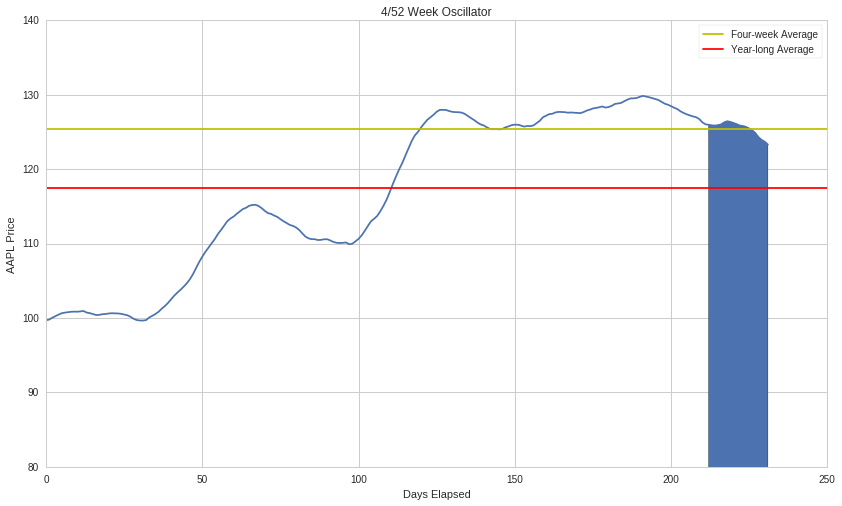

In [9]:
# get two averages
av_4w = np.nanmean(AAPL_frame[-20:])
av_52w = np.nanmean(AAPL_frame)

# create the graph
plt.plot(days, AAPL_frame)
plt.fill_between(days[-20:], AAPL_frame[-20:])
plt.axhline(av_4w, color='y', label='Four-week Average' )
plt.axhline(av_52w, color='r', label='Year-long Average')
plt.ylim([80,140])
plt.xlabel('Days Elapsed')
plt.ylabel('AAPL Price')
plt.title('4/52 Week Oscillator')
plt.legend();


The section shaded blue under the graph represents the last four weeks of close prices. The fact that this average (shown by the yellow line) is greater than the year-long average (shown by the red line), means that the 4/52 week oscillator for this date will be positive. This fact is backed by our pipeline output, which gives the value of the metric to be 9.4%. 

##39-Week Return

This is calculated as the difference price between today and 39-weks prior, all over the price 39-weeks prior.

Although returns as a metric might seem too ubitquitous to be useful or special, the important thing to highlight hear is the window length chosen. By choosing a larger window length (here, 39-weeks) as opposed to daily returns, we see larger fluctuations in value. This is because a larger time window exposes the metric to larger trends and higher volatility. 

In the graph below, we illustrate this point by plotting returns calculated over different time windows. To do this we will look at a AAPL close prices between 2002 and 2016. We will also mark important dates in the history of Apple in order to highlight this metric's descriptive power for larger trends.

NB: 39-week return is not a metric that is event driven. The inclusion of these dates is illustrative as opposed to predictive.

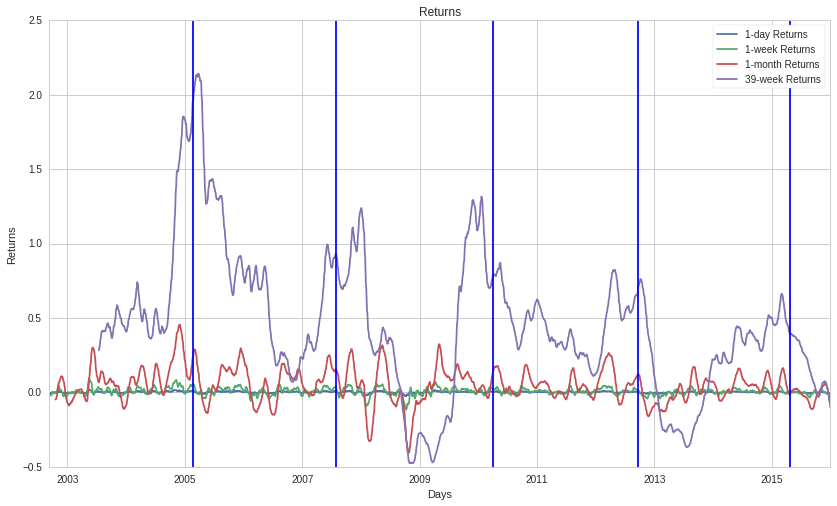

In [10]:
# create a new longer frame of AAPL close prices
AAPL_frame = get_pricing('AAPL', start_date='2002-08-08', end_date='2016-01-01', fields='close_price')

# use dates as index
AAPL_index = AAPL_frame.index[20:]
AAPL_frame = lag_helper(AAPL_frame.as_matrix())

# 1d returns
AAPL_1d_returns = ((AAPL_frame - np.roll(AAPL_frame, 1))/ np.roll(AAPL_frame,1))[1:]

# 1w returns
AAPL_1w_returns = ((AAPL_frame - np.roll(AAPL_frame, 5))/ np.roll(AAPL_frame, 5))[5:]

# 1m returns
AAPL_1m_returns = ((AAPL_frame - np.roll(AAPL_frame, 30))/ np.roll(AAPL_frame, 30))[30:]

# 39w returns
AAPL_39w_returns = ((AAPL_frame - np.roll(AAPL_frame, 215))/ np.roll(AAPL_frame, 215))[215:]

# plot close prices
plt.plot(AAPL_index[1:], AAPL_1d_returns, label='1-day Returns')
plt.plot(AAPL_index[5:], AAPL_1w_returns, label='1-week Returns')
plt.plot(AAPL_index[30:], AAPL_1m_returns, label='1-month Returns')
plt.plot(AAPL_index[215:], AAPL_39w_returns, label='39-week Returns')

# show events
# iPhone release
plt.axvline('2007-07-29')
# iPod mini 2nd gen. release
plt.axvline('2005-02-23')
# iPad release
plt.axvline('2010-04-03')
# iPhone 5 release
plt.axvline('2012-09-21')
# Apple Watch
plt.axvline('2015-04-24')

# labels
plt.xlabel('Days')
plt.ylabel('Returns')
plt.title('Returns')
plt.legend();

There are a few important characteristics to note on the graph above.

Firstly, as we expected, the amplitude of the signal of returns with a longer window length is larger.

Secondly, these new releases, many of which were announced several months before, all lie in or adjacent to a peak in the 39-week return price. Therefore, it would seem that this window length is a useful tool for capturing information on larger trends.

Now let us create the custom factor and run the Pipeline.

In [11]:
# Custom Fator 4: 39-week Returns
def return_helper(col):
    if nan_check(col):
        return np.nan 
    else:
        col = lag_helper(col)
        return (col[-1] - col[-215]) / col[-215]

class Return_39_Week(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 235
    
    def compute(self, today, assets, out, close):
        out[:] = np.apply_along_axis(return_helper, 0, close)
        
temp_pipe_4 = Pipeline()
temp_pipe_4.add(Return_39_Week(), '39 Week Return')
results_4 = run_pipeline(temp_pipe_4, '2015-08-08','2015-08-08')
results_4.head(20)

39 Week Return
2015-08-10 00:00:00+00:00 Equity(2 [AA])           -0.381646
                          Equity(21 [AAME])              NaN
                          Equity(24 [AAPL])         0.243775
                          Equity(25 [AA_PR])             NaN
                          Equity(31 [ABAX])         0.020425
                          Equity(39 [DDC])         -0.074306
                          Equity(41 [ARCB])        -0.126575
                          Equity(52 [ABM])          0.227928
                          Equity(53 [ABMD])         2.081958
                          Equity(62 [ABT])          0.206293
                          Equity(64 [ABX])         -0.515709
                          Equity(66 [AB])           0.092714
                          Equity(67 [ADSK])        -0.043848
                          Equity(69 [ACAT])        -0.153872
                          Equity(70 [VBF])         -0.013950
                          Equity(76 [TAP])         -0.023681
                          Equity(84 [ACET])         0.191040
                          Equity(86 [ACG])          0.045309
                          Equity(88 [ACI])         -0.943585
                          Equity(100 [IEP])        -0.207704

##Aggregation

Let us create the full Pipeline. Once again we will need a proxy for the S&P500 for the ordering logic. Also, given the large window lengths needed for the algorithm, we will employ the trick of multiple outputs per factor. This is explained in detail here (https://www.quantopian.com/posts/new-feature-multiple-output-pipeline-custom-factors). Instead of having to process several data frames, we only need to deal with one large one and then apply our helper functions. This will speed up out computation exponentially in the backtester.

In [12]:
# This factor creates the synthetic S&P500
class SPY_proxy(CustomFactor):
    inputs = [morningstar.valuation.market_cap]
    window_length = 1
    
    def compute(self, today, assets, out, mc):
        out[:] = mc[-1]

# using helpers to boost speed
class Pricing_Pipe(CustomFactor):
    
    inputs = [USEquityPricing.close]
    outputs = ['trendline', 'percent', 'oscillator', 'returns']
    window_length=280
    
    def compute(self, today, assets, out, close):
        out.trendline[:] = np.apply_along_axis(trendline_function, 0, close[-272:], True)
        out.percent[:] = np.apply_along_axis(percent_helper, 0, close)
        out.oscillator[:] =  np.apply_along_axis(oscillator_helper, 0, close[-272:])
        out.returns[:] = np.apply_along_axis(return_helper, 0, close[-235:])
        
def Data_Pull():
    
    # create the piepline for the data pull
    Data_Pipe = Pipeline()
    
    # create SPY proxy
    Data_Pipe.add(SPY_proxy(), 'SPY Proxy')

    # run all on same dataset for speed
    trendline, percent, oscillator, returns = Pricing_Pipe()
    
    # add the calculated values
    Data_Pipe.add(trendline, 'Trendline')
    Data_Pipe.add(percent, 'Percent')
    Data_Pipe.add(oscillator, 'Oscillator')
    Data_Pipe.add(returns, 'Returns')
        
    return Data_Pipe

results = run_pipeline(Data_Pull(), '2015-08-08', '2015-08-08')
results.head(20)

Oscillator   Percent   Returns  \
2015-08-10 00:00:00+00:00 Equity(2 [AA])       -0.271287  0.000000 -0.381646   
                          Equity(21 [AAME])          NaN       NaN       NaN   
                          Equity(24 [AAPL])     0.089667  0.314374  0.243775   
                          Equity(25 [AA_PR])         NaN       NaN       NaN   
                          Equity(31 [ABAX])    -0.046013  0.189924  0.020425   
                          Equity(39 [DDC])     -0.159902  0.000000 -0.074306   
                          Equity(41 [ARCB])    -0.163490  0.020620 -0.126575   
                          Equity(52 [ABM])      0.120786  0.327307  0.227928   
                          Equity(53 [ABMD])     0.473859  2.256132  2.081958   
                          Equity(62 [ABT])      0.107602  0.238078  0.206293   
                          Equity(64 [ABX])     -0.269565  0.000000 -0.515709   
                          Equity(66 [AB])       0.059691  0.175879  0.092714   
                          Equity(67 [ADSK])    -0.083954  0.006031 -0.043848   
                          Equity(69 [ACAT])    -0.063122  0.000000 -0.153872   
                          Equity(70 [VBF])     -0.022971  0.004431 -0.013950   
                          Equity(76 [TAP])     -0.030247  0.029064 -0.023681   
                          Equity(84 [ACET])     0.154912  0.415219  0.191040   
                          Equity(86 [ACG])      0.011582  0.054047  0.045309   
                          Equity(88 [ACI])     -0.816684  0.000000 -0.943585   
                          Equity(100 [IEP])    -0.108132  0.000000 -0.207704   

                                                 SPY Proxy  Trendline  
2015-08-10 00:00:00+00:00 Equity(2 [AA])      1.189590e+10  -0.020134  
                          Equity(21 [AAME])   7.612130e+07        NaN  
                          Equity(24 [AAPL])   6.537600e+11   0.134210  
                          Equity(25 [AA_PR])           NaN        NaN  
                          Equity(31 [ABAX])   1.118860e+09   0.026059  
                          Equity(39 [DDC])    1.039750e+09   0.027155  
                          Equity(41 [ARCB])   8.785140e+08  -0.015297  
                          Equity(52 [ABM])    1.857790e+09   0.032766  
                          Equity(53 [ABMD])   3.706250e+09   0.185881  
                          Equity(62 [ABT])    7.519710e+10   0.030551  
                          Equity(64 [ABX])    7.919750e+09  -0.044889  
                          Equity(66 [AB])     2.922680e+09   0.034333  
                          Equity(67 [ADSK])   1.232740e+10  -0.009252  
                          Equity(69 [ACAT])   3.598240e+08  -0.014448  
                          Equity(70 [VBF])             NaN  -0.000941  
                          Equity(76 [TAP])    1.291870e+10   0.006323  
                          Equity(84 [ACET])   6.839320e+08   0.026783  
                          Equity(86 [ACG])             NaN   0.001448  
                          Equity(88 [ACI])    3.215040e+07  -1.289812  
                          Equity(100 [IEP])   9.785680e+09  -0.078825

We will now use the Lo/Patel ranking logic described in the Traditional Value notebook (https://www.quantopian.com/posts/quantopian-lecture-series-long-slash-short-traditional-value-case-study) in order to combine these desriptive metrics into a single factor.

NB: `standard_frame_compute` and `composite_score` have been combined into a single function called `aggregate_data`.

In [13]:
# limit effect of outliers
def filter_fn(x):
    if x <= -10:
        x = -10.0
    elif x >= 10:
        x = 10.0
    return x   

# combine data
def aggregate_data(df):

    # basic clean of dataset to remove infinite values
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()

    # need standardization params from synthetic S&P500
    df_SPY = df.sort(columns='SPY Proxy', ascending=False)

    # create separate dataframe for SPY
    # to store standardization values
    df_SPY = df_SPY.head(500)

    # get dataframes into numpy array
    df_SPY = df_SPY.as_matrix()

    # store index values
    index = df.index.values

    # get data intp a numpy array for speed
    df = df.as_matrix()

    # get one empty row on which to build standardized array
    df_standard = np.empty(df.shape[0])

    for col_SPY, col_full in zip(df_SPY.T, df.T):

        # summary stats for S&P500
        mu = np.mean(col_SPY)
        sigma = np.std(col_SPY)
        col_standard = np.array(((col_full - mu) / sigma))

        # create vectorized function (lambda equivalent)
        fltr = np.vectorize(filter_fn)
        col_standard = (fltr(col_standard))

        # make range between -10 and 10
        col_standard = (col_standard / df.shape[1])

        # attach calculated values as new row in df_standard
        df_standard = np.vstack((df_standard, col_standard))

    # get rid of first entry (empty scores)
    df_standard = np.delete(df_standard, 0, 0)

    # sum up transformed data
    df_composite = df_standard.sum(axis=0)

    # put into a pandas dataframe and connect numbers
    # to equities via reindexing
    df_composite = pd.Series(data=df_composite, index=index)

    # sort descending
    df_composite.sort(ascending=False)

    return df_composite

ranked_scores = aggregate_data(results)
ranked_scores

(2015-08-10 00:00:00+00:00, Equity(40442 [ANAC]))    5.909706
(2015-08-10 00:00:00+00:00, Equity(39270 [ANTH]))    5.829848
(2015-08-10 00:00:00+00:00, Equity(46354 [EGRX]))    5.827141
(2015-08-10 00:00:00+00:00, Equity(22651 [HRTX]))    5.825644
(2015-08-10 00:00:00+00:00, Equity(47191 [ADPT]))    5.564333
(2015-08-10 00:00:00+00:00, Equity(46871 [RDUS]))    5.417749
(2015-08-10 00:00:00+00:00, Equity(39804 [VLTC]))    5.415383
(2015-08-10 00:00:00+00:00, Equity(33062 [SRNE]))    5.396920
(2015-08-10 00:00:00+00:00, Equity(44935 [BLUE]))    5.154398
(2015-08-10 00:00:00+00:00, Equity(46869 [ALDR]))    5.152219
(2015-08-10 00:00:00+00:00, Equity(32497 [HBI]))     5.131514
(2015-08-10 00:00:00+00:00, Equity(44689 [RCPT]))    5.039724
(2015-08-10 00:00:00+00:00, Equity(40992 [ADXS]))    5.007482
(2015-08-10 00:00:00+00:00, Equity(13867 [IMH]))     4.982655
(2015-08-10 00:00:00+00:00, Equity(31341 [ZIOP]))    4.851253
(2015-08-10 00:00:00+00:00, Equity(32331 [SGYP]))    4.805818
(2015-08

##Stock Choice

Now that we have our ranking system, let us have a look at the histogram of the ranked scores. This will allow us to see general trends in the metric and diagnose any issues with our ranking system as a factor. The red lines give our cut-off points for our trading baskets

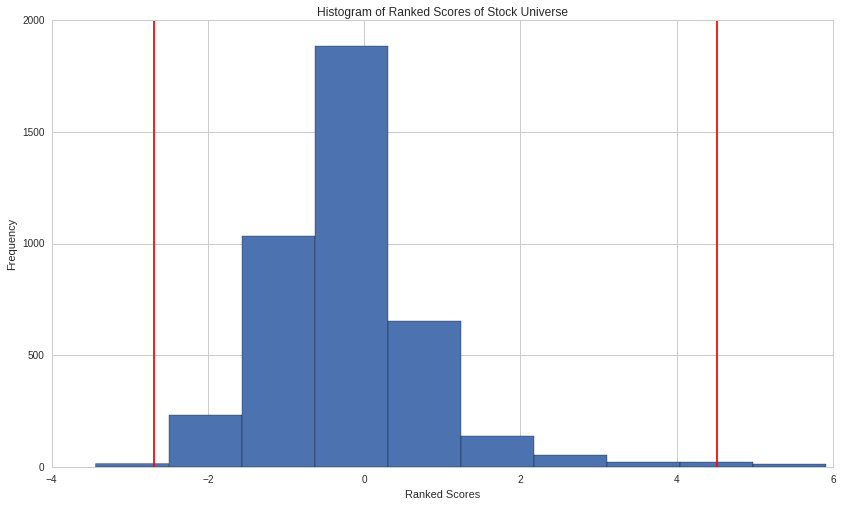

In [14]:
# histogram
ranked_scores.hist()

# baskets
plt.axvline(ranked_scores[26], color='r')
plt.axvline(ranked_scores[-6], color='r')
plt.xlabel('Ranked Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Ranked Scores of Stock Universe');

Although there does appear to be some positive skew, this looks to be a robust metric as the tails of this distribution are very thin. A thinner tail means that our ranking system has identified special characteristics about our stock universe possessed by only a few equities. More thorough statistical analysis would have to be conducted in order to see if this strategy could generate good alpha returns. This robust factor analysis will be covered in a later notebook.

Please see the attached algorithm for a full implementation!

*The material on this website is provided for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation or endorsement for any security or strategy, nor does it constitute an offer to provide investment advisory or other services by Quantopian.*

*In addition, the content of the website neither constitutes investment advice nor offers any opinion with respect to the suitability of any security or any specific investment. Quantopian makes no guarantees as to accuracy or completeness of the views expressed in the website. The views are subject to change, and may have become unreliable for various reasons, including changes in market conditions or economic circumstances.*